In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv("../Data/inmuebles-sample.csv")

In [3]:
# Normalizar valores en la columna 'operation'
df['operation'] = df['operation'].str.lower()  # pasar todo a minúsculas para estandarizar

# Reemplazar 'venta' por 'buy' y 'alquiler' por 'rent'
df['operation'] = df['operation'].replace({
    'venta': 'buy',
    'alquiler': 'rent'
})

# Pasar todo a mayúsculas final
df['operation'] = df['operation'].str.upper()

In [4]:
# Filtrar solo pisos en alquiler en Santa Cruz de Tenerife
df_sc = df[(df['province'].str.lower() == 'santa-cruz-de-tenerife') & (df['operation'] == 'RENT')].copy()

# Revisamos qué tenemos
print(f"Total de registros: {len(df_sc)}")
print(df_sc[['price', 'area', 'rooms', 'baths', 'location', 'property_type']].info())

Total de registros: 314
<class 'pandas.core.frame.DataFrame'>
Index: 314 entries, 0 to 410
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          314 non-null    float64
 1   area           314 non-null    float64
 2   rooms          274 non-null    float64
 3   baths          314 non-null    float64
 4   location       314 non-null    object 
 5   property_type  314 non-null    object 
dtypes: float64(4), object(2)
memory usage: 17.2+ KB
None


In [5]:
# Crear variable auxiliar de precio por m²
df_sc['price_per_m2'] = df_sc['price'] / df_sc['area']

# Eliminar filas con nulos en variables clave
df_modelo = df_sc.dropna(subset=['price', 'area', 'rooms', 'baths'])

# Seleccionar variables para el modelo
X = df_modelo[['area', 'rooms', 'baths']]
y = df_modelo['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

modelo = LinearRegression()
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

MAE: 311.3488500031792
R2: 0.1475181737517537


c:\Users\heatb\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\heatb\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\heatb\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\heatb\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\heatb\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _wina

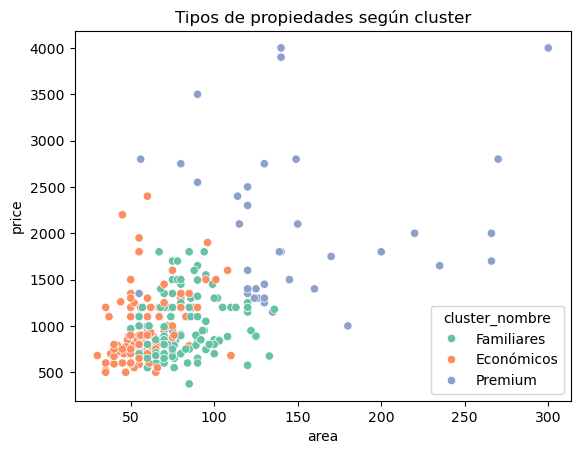

In [6]:
# Usamos área, rooms, baths y precio para clustering
X_cluster = df_modelo[['area', 'rooms', 'baths', 'price']].copy()
X_scaled = StandardScaler().fit_transform(X_cluster)

# Probar con 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df_modelo['cluster'] = kmeans.fit_predict(X_scaled)

# Perfil de cada cluster
df_modelo.groupby('cluster')[['price', 'area', 'rooms', 'baths']].mean()

# Renombrar según análisis
nombres_clusters = {
    0: 'Económicos',
    1: 'Familiares',
    2: 'Premium'
}

df_modelo['cluster_nombre'] = df_modelo['cluster'].map(nombres_clusters)

# Visualización con nombres
sns.scatterplot(data=df_modelo, x='area', y='price', hue='cluster_nombre', palette='Set2')
plt.title('Tipos de propiedades según cluster')
plt.show()

Viendo que el R2 y el Error Cuadratico Medio no son los resultados que esperamos, vamos a intentar implementar más robustez al modelo. 

1. Incluiremos mas variables al modelo, en este caso "Location" y "property_type"
2. Si el modelo sigue sin robustez, incluiremos más variables de fuera del dataset o haremos algún tipo de transformación (normalización o estandarización).
3. Volvemos a entrenar el modelo

In [7]:
# Copiamos el dataframe ya limpio para el modelo
df_modelo = df_sc.dropna(subset=['price', 'area', 'rooms', 'baths', 'location', 'property_type'])

# Creamos las variables dummies
df_dummies = pd.get_dummies(df_modelo, columns=['location', 'property_type'], drop_first=True)

# Definimos variables predictoras y objetivo
X = df_dummies.drop(columns=['price', 'price_per_m2', 'reference', 'title', 'description', 'url'])
y = df_dummies['price']


In [8]:
# Eliminar columnas con NaNs totales
X = X.drop(columns=['floor', 'floor.1', 'elevator', 'outside'], errors='ignore')

print(X.isna().sum().sum())  # debería dar 0

0


In [9]:
df_model_input = pd.concat([X, y], axis=1).dropna()
X_clean = df_model_input.drop(columns=['price'])
y_clean = df_model_input['price']

In [10]:
# Asegurar que X solo contiene columnas numéricas
X = df_dummies.select_dtypes(include=['number', 'bool'])

print(df_dummies.select_dtypes(include='object').columns.tolist())

['website', 'url', 'reference', 'country', 'province', 'title', 'description', 'operation', 'dealer', 'dealer_url']


In [11]:
# 1. Filtrar solo pisos de alquiler en Santa Cruz de Tenerife
df_sc = df[(df['province'] == 'santa-cruz-de-tenerife') & (df['operation'] == 'RENT')].copy()

# 2. Eliminar columnas que sabemos que no tienen datos útiles
df_sc.drop(columns=['elevator', 'outside', 'floor', 'floor.1'], inplace=True, errors='ignore')

# 3. Eliminar columnas tipo texto innecesarias para el modelo
df_sc.drop(columns=['url', 'title', 'description', 'reference', 'website', 'dealer_url', 'dealer'], inplace=True, errors='ignore')

# 4. Eliminar registros con NaNs en las columnas clave
df_sc = df_sc.dropna(subset=['price', 'area', 'rooms', 'baths', 'location', 'property_type'])

# 5. Crear dummies de las columnas categóricas
df_model = pd.get_dummies(df_sc, columns=['location', 'property_type'], drop_first=True)

# 6. Separar variables predictoras y target
X = df_model.drop(columns=['price', 'price_per_m2'], errors='ignore')
y = df_model['price']

# 7. Asegurar que no quedan NaNs en X
X = X.fillna(X.median(numeric_only=True))

# 8. Confirmación de que X no tiene NaNs
print("NaNs en X:", X.isna().sum().sum())  # debería dar 0

NaNs en X: 0


In [12]:
# Asegurarnos de que X contiene solo columnas numéricas
X = X.select_dtypes(include=['number', 'bool'])

print(X.columns[X.dtypes == 'object'])

Index([], dtype='object')


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

modelo = RandomForestRegressor(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

MAE: 248.24072727272727
R2: 0.45692353686617915


Utilizamos GridSearchCV para hallar la mejor combinación de hiperparámetros del modelo. Hacemos una validación cruzada (en este caso de 3 folds) y nos indicará la mejor combinación de parámetros para obtener el mejor rendimiento.

In [14]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Mejores parámetros:", grid_search.best_params_)
print("Mejor score:", grid_search.best_score_)


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Mejores parámetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mejor score: 0.5092176534289866


. max_depth: 10: Este es el número máximo de niveles (profundidad) que los árboles pueden tener. Limitar la profundidad de los árboles ayuda a evitar el sobreajuste (overfitting), ya que un árbol más profundo puede ajustarse demasiado a los datos de entrenamiento, y perder capacidad de generalización en nuevos datos.

. min_samples_split: 2: Este es el número mínimo de muestras necesarias para dividir un nodo. En este caso, el valor es el más bajo posible (2), lo que significa que los árboles se van a dividir con muy pocos datos, permitiendo más flexibilidad en la división de los nodos.

. min_samples_leaf: 1: Es el número mínimo de muestras necesarias en una hoja (el nodo final). En este caso, también se permite un número mínimo bajo (1), lo que significa que los árboles pueden terminar con solo una muestra por hoja.

. n_estimators: 100: Este es el número de árboles en el modelo Random Forest. Un mayor número de árboles generalmente mejora el rendimiento, pero también aumenta el tiempo de entrenamiento.

In [15]:
import plotly.express as px
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Entrenamiento final con el mejor modelo encontrado
mejor_modelo = grid_search.best_estimator_

# Importancia de las variables
importancias = mejor_modelo.feature_importances_
features = X.columns

df_importancia = pd.DataFrame({
    'Feature': features,
    'Importance': importancias
}).sort_values(by='Importance', ascending=False).head(15)  # Top 15

fig = px.bar(
    df_importancia,
    x='Importance',
    y='Feature',
    orientation='h',
    title='Top 15 Most Important Features in Price Prediction',
    color='Importance',
    color_continuous_scale='Viridis'
)

fig.update_layout(yaxis=dict(autorange="reversed"))
fig.show()


In [16]:
import plotly.express as px
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, r2_score

# Ya tienes y_pred e y_test del modelo
resultados = pd.DataFrame({
    'Actual Price': y_test.values,
    'Predicted Price': y_pred
})

# Métricas rápidas para el título
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

fig = px.scatter(
    resultados,
    x='Actual Price',
    y='Predicted Price',
    title=f'Real vs Predicted Prices (R²={r2:.2f}, RMSE={rmse:.0f} €)',
    labels={'Actual Price': 'Actual Price (€)', 'Predicted Price': 'Predicted Price (€)'},
    trendline="ols",
    opacity=0.6
)

fig.update_traces(marker=dict(color='blue'))
fig.add_shape(
    type='line',
    x0=resultados['Actual Price'].min(),
    y0=resultados['Actual Price'].min(),
    x1=resultados['Actual Price'].max(),
    y1=resultados['Actual Price'].max(),
    line=dict(color='green', dash='dash'),
    name='Ideal Fit'
)
fig.show()

c:\Users\heatb\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

